### Project Work for the course "Reproducible and Interactive Data Science"

Christian Sahlholdt,  Department of Astronomy and Theoretical Physics

# Testing Asteroseismic Radii of Dwarf Stars with Gaia Parallaxes

In this notebook we derive the distances, and thereby [parallaxes](https://en.wikipedia.org/wiki/Stellar_parallax), of a sample of almost a hundred dwarf stars based on their radii obtained from [asteroseismology](https://en.wikipedia.org/wiki/Asteroseismology).
By comparing these parallaxes to the ones measured by the [Gaia spacecraft](http://www.esa.int/Our_Activities/Space_Science/Gaia_overview), we test the accuracy of the asteroseismic radii.

To run this notebook, the packages listed in the file `environment.yml` must be installed.

## Contents
* [Introduction](#intro)


* [Seismic Parallaxes](#seis_plx)
    * [Stellar Data](#stel_data)
    * [Scaling Relation Parameters](#scal_par)
    * [Calculation of Parallaxes](#plx_calc)


* [Comparison with Gaia Parallaxes](#gaia_comp)
    * [Error Distributions](#err_dist)
    * [Absolute Differences](#abs_diff)
    * [Relative Differences](#rel_diff)


* [Correcting the Scaling Relations](#scal_corr)


* [References](#ref)

## Introduction <a class="anchor" id="intro"></a>

Precise and accurate stellar parameters like masses, radii, and ages are crucial in many different fields of astronomy.
In recent years, the field of asteroseismology, which is the study of intrinsic stellar oscillations, has seen great progress as a means of determining stellar parameters with high precision.
Just like seismic measurements of earthquakes reveal the inner structure of Earth, measurements of stellar pulsations provide information about the star's interior.
For a star like the Sun, the outer layers undergo powerful convective motion which excites a rich spectrum of oscillation modes, and each individual pulsation carries information about the stellar structure.
This enables a determination of the stellar properties by matching the observed oscillations to those of a stellar model.

It is not always possible to determine the individual oscillation frequencies due to their very low amplitudes. However, usually two global parameters can be determined from the oscillations, namely the
mean frequency separation and the frequency of maximum oscillation power.
These parameters follow a set of approximate *scaling relations*, tying them to the mass, radius, and temperature of the star, which makes it straightforward to estimate properties of any star with detected solar-like oscillations.

Since asteroseismology holds such great potential for determining precise stellar parameters, it is important to verify that the results are also accurate.
Unfortunately, direct measurements of radii and masses are very difficult to obtain -- especially in the large quantities possible by asteroseismology.
In order to test the results of asteroseismology for large stellar samples, less direct comparisons must be employed.
One approach is to use the radius from asteroseismology with an independent measurement of the angular diameter.
When combined, this gives an asteroseismic distance which can be compared with the value from a more direct measurement like that given by the trigonometric parallax.
[Silva Aguirre et al. (2012)](http://iopscience.iop.org/article/10.1088/0004-637X/757/1/99/meta) used the scaling relations to derive stellar distances which they compared to the parallaxes measured by the [Hipparcos spacecraft](http://www.esa.int/Our_Activities/Space_Science/Hipparcos_overview).
Based on their sample of 22 dwarf stars, they found the asteroseismic distances
-- and thereby also the radii -- to be accurate to within 4%.

With the recent release of parallaxes from the Gaia mission, a new opportunity to test asteroseismic distances has arisen.
This release has significantly increased the number of solar-like oscillators with precise parallax measurements and puts new observational constraints on the asteroseismic results.

In this notebook we focus on a little less than a hundred dwarf stars which have some of the most precisely determined oscillation frequencies.
These stars have had their individual frequencies measured, so we will test the seismic radii from both a detailed model fit of the individual frequencies and from the approximate scaling relations.

## Seismic Parallaxes <a class="anchor" id="seis_plx"></a>

The first step in the analysis is to derive the parallaxes of the stars based on their seismic radii.

In this section the available data is presented, and we derive parallaxes based on the asteroseismic stellar parameters.

### Stellar Data <a class="anchor" id="stel_data"></a>

The data is stored in three files. First of all we have the observed stellar parameters in the file `star_obs.txt`. The first column holds an ID number of the star, and the following columns hold the value and uncertainty of a number of observables.

In [1]:
!head -n15 data/star_obs.txt

# Observational parameters
#
# Columns (the ones left out contain the uncertainties on the previous parameter):
# 0 - KIC ID
# 1 - Effective temperature (K)
# 3 - Metallicity ([Fe/H])
# 5 - Large frequency separation (dnu) (microHz)
# 7 - Frequency of maximum power (nu_max) (microHz)
# 9 - Angular diameter (arcseconds)
############################################################################################
 1435467	6382	 80	 0.01	0.10	 70.331	0.219	1405.99	  8.07	1.15e-01	3.63e-03
 2837475	6675	 81	 0.01	0.10	 75.759	0.197	1560.83	  9.69	1.27e-01	5.46e-03
 3425851	6469	 80	-0.04	0.10	 92.600	1.500	2038.00	 60.00	5.21e-02	1.30e-03
 3427720	6037	 79	-0.06	0.10	119.866	0.183	2729.47	 14.99	1.14e-01	5.45e-03
 3456181	6626	134	-0.15	0.10	 52.046	0.234	 971.39	  7.72	8.00e-02	2.23e-03


In the file `star_mass_rad.txt` we have stellar masses, radii, and surface gravities derived by fitting stellar models to the individual stellar oscillation frequencies using the BAyesian STellar Algorithm (BASTA, see [Silva Aguirre et al. (2015)](https://academic.oup.com/mnras/article-abstract/452/2/2127/1064904)).

In [2]:
!head -n13 data/star_mass_rad.txt

# Stellar radii, masses, and surface gravities from detailed asteroseismic analysis
#
# Columns (the ones left out contain the uncertainties on the previous parameter):
# 0 - KIC ID
# 1 - Radius (solar units)
# 3 - Mass (solar units)
# 5 - Surface gravity (log10(g/cm^3))
#################################################################################
 1435467	1.699e+00	2.379e-02	1.350e+00	4.038e-02	4.109e+00	8.965e-03
 2837475	1.623e+00	2.283e-02	1.382e+00	4.500e-02	4.159e+00	1.184e-02
 3425851	1.365e+00	1.961e-02	1.212e+00	4.870e-02	4.251e+00	1.015e-02
 3427720	1.122e+00	1.064e-02	1.121e+00	1.984e-02	4.388e+00	4.159e-03
 3456181	2.105e+00	3.298e-02	1.493e+00	3.554e-02	3.966e+00	1.168e-02


Finally, the file `star_par.txt` contains the Gaia parallaxes which will be used for comparison.

In [3]:
!head -n11 data/star_par.txt

# Stellar Parallaxes from Gaia mission
#
# Columns (the ones left out contain the uncertainties on the previous parameter):
# 0 - KIC ID
# 1 - Gaia parallax (mas)
########################
 1435467	 5.60	0.25
 2837475	 7.94	0.26
 3425851	 3.94	0.24
 3427720	10.51	0.26
 3456181	 3.83	0.27


Before we can load the data we import `numpy` and `pandas` for handling the data and `matplotlib` for plotting.

In [4]:
# Import packages to be used for data analysis and plotting
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [5]:
# The default matplotlib settings are restored (just to be sure) and the default figure size is updated
plt.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (5, 5)})

Using `pandas` we load the data from each file into a separate `DataFrame` with the stellar ID as the index.

In [6]:
# Names to use for the columns in the different files
obs_names = ['ID', 'teff', 'teff_unc', 'feh', 'feh_unc', 'dnu', 'dnu_unc',
             'numax', 'numax_unc', 'angdiam', 'angdiam_unc']
mass_rad_names = ['ID', 'rad', 'rad_unc', 'mass', 'mass_unc', 'logg', 'logg_unc']
plx_names = ['ID', 'plx', 'plx_unc']

# Read data into DataFrames
star_obs = pd.read_table('data/star_obs.txt', header=None, skiprows=10,
                         names=obs_names, index_col=0)
star_mr = pd.read_table('data/star_mass_rad.txt', header=None, skiprows=8,
                         names=mass_rad_names, index_col=0)
star_plx = pd.read_table('data/star_par.txt', header=None, skiprows=6,
                         names=plx_names, index_col=0)

print('Number of stars with asteroseismic parameters: ', len(star_mr))
print('Number of stars with Gaia parallaxes: ', len(star_plx))

Number of stars with asteroseismic parameters:  95
Number of stars with Gaia parallaxes:  86


Not all of the stars with asteroseismic parameters were included in the first data release from the Gaia mission.
We restrict the analysis to the 86 stars with Gaia parallaxes by joining the three data sets on the indices of the parallax data.

In [7]:
# Combine the DataFrames while excluding the stars without Gaia parallaxes
sa = star_plx.join([star_obs, star_mr], how='inner')
n_star = len(sa)
# Add columns for every parameter which will be derived later
for new_name in ['rad_scal', 'rad_scal_unc', 'mass_scal', 'mass_scal_unc',
                 'plx_rad', 'plx_rad_unc', 'plx_scal', 'plx_scal_unc',
                 'dnu_scal', 'dnu_scal_unc', 'numax_scal', 'numax_scal_unc']:
    sa[new_name] = np.zeros(n_star)

# The DataFrame is converted into a NumPy "Records array" since we don't need
# the indices of the DataFrame. This makes it easier to work with the data values.
sa = sa.to_records();

### Scaling Relation Parameters <a class="anchor" id="scal_par"></a>

As mentioned above, the masses and radii of the stars, which are included in the data we have just loaded, come from a detailed asteroseismic analysis using all individual oscillation frequencies.
When individual frequencies are not available, it is possible to derive masses and radii using the average parameters of the frequency spectrum; the large frequency separation, $\Delta\nu$, and the frequency of maximum power, $\nu_{\mathrm{max}}$. The figure below shows a power spectrum of the Sun and the two average parameters.

![solar_ps](solar_ps_average.pdf "Power spectrum of the Sun")

The average parameters follow a set of approximate scaling relations given by ([Chaplin and Miglio (2013)](http://www.annualreviews.org/doi/full/10.1146/annurev-astro-082812-140938)):

\begin{align}
  \frac{\Delta\nu}{\Delta\nu_{\odot}} &\simeq \left(\frac{M}{M_{\odot}}\right)^{1/2}
                                              \left(\frac{R}{R_{\odot}}\right)^{-3/2}
                                              \label{eq:dnu_scal} \; ,
  \\
  \frac{\nu_{\mathrm{max}}}{\nu_{\mathrm{max},\odot}} &\simeq
                          \left(\frac{M}{M_{\odot}}\right)
                          \left(\frac{R}{R_{\odot}}\right)^{-2}
                          \left(\frac{T_{\mathrm{eff}}}{T_{\mathrm{eff},\odot}}\right)^{-1/2}
                          \label{eq:numax_scal} \; ,
\end{align}

which can be rearranged to give the scaling relations for the radius and mass:

\begin{align}
  \frac{R}{R_{\odot}} &\simeq \left(\frac{\nu_{\mathrm{max}}}{\nu_{\mathrm{max},\odot}}\right)
                              \left(\frac{\Delta\nu}{\Delta\nu_{\odot}}\right)^{-2}
                              \left(\frac{T_{\mathrm{eff}}}{T_{\mathrm{eff},\odot}}\right)^{1/2}
                              \; , \label{eq:R_scal} \\
  \frac{M}{M_{\odot}} &\simeq \left(\frac{\nu_{\mathrm{max}}}{\nu_{\mathrm{max},\odot}}\right)^{3}
                              \left(\frac{\Delta\nu}{\Delta\nu_{\odot}}\right)^{-4}
                              \left(\frac{T_{\mathrm{eff}}}{T_{\mathrm{eff},\odot}}\right)^{3/2}
                              \; . \label{eq:M_scal}
\end{align}

In the code below, the scaling relations are implemented and and applied to the data.
We calculate scaling relation masses and radii based on the observed $\Delta\nu$, $\nu_{\mathrm{max}}$, and effective temperature, and we calculate scaling relation $\Delta\nu$ and $\nu_{\mathrm{max}}$ from the masses and radii given by the individual frequency analysis.

In [8]:
def scal_mr(dnu, numax, teff):
    '''
    Calculate mass and radius using the seismic scaling relations.
    '''
    # Constants
    dnusun = 135.1
    numaxsun = 3090.
    teffsun = 5777.

    # Scaling relations
    mass = np.power(numax/numaxsun, 3) * np.power(dnu/dnusun, -4) * np.power(teff/teffsun, 3/2)
    rad = (numax/numaxsun) * np.power(dnu/dnusun, -2) * np.power(teff/teffsun, 1/2)

    return mass, rad

def scal_mr_unc(dnu, dnu_unc, numax, numax_unc, teff, teff_unc, n_MC=1000):
    '''
    Calculate uncertainties on mass and radius by MC sampling.
    '''
    n = len(dnu)
    mass_unc, rad_unc = np.zeros(n), np.zeros(n)
    
    for i in range(n):
        teff_synth = np.random.normal(teff[i], teff_unc[i], n_MC)
        dnu_synth = np.random.normal(dnu[i], dnu_unc[i], n_MC)
        numax_synth = np.random.normal(numax[i], numax_unc[i], n_MC)

        mass_synth, rad_synth = scal_mr(dnu_synth, numax_synth, teff_synth)
        mass_unc[i], rad_unc[i] = np.std(mass_synth), np.std(rad_synth)

    return mass_unc, rad_unc

In [9]:
# Scaling relation masses and radii as well as uncertainties
# are calculated and stored in the data array
sa.mass_scal, sa.rad_scal = scal_mr(sa.dnu, sa.numax, sa.teff)
sa.mass_scal_unc, sa.rad_scal_unc = scal_mr_unc(sa.dnu, sa.dnu_unc,
                                                sa.numax, sa.numax_unc,
                                                sa.teff, sa.teff_unc)

In [10]:
def scal_dn(mass, rad, teff):
    '''
    Calculate $\Delta\nu$ and $\nu_{\mathrm{max}}$ using the seismic scaling relations.
    '''
    # Constants
    dnusun = 135.1
    numaxsun = 3090.
    teffsun = 5777.

    dnu = np.power(mass, 1/2) * np.power(rad, -3/2) * dnusun
    numax = mass * np.power(rad, -2) * np.power(teff / teffsun, -1/2) * numaxsun

    return dnu, numax

def scal_dn_unc(mass, mass_unc, rad, rad_unc, teff, teff_unc, n_MC=1000):
    '''
    Calculate uncertainties on $\Delta\nu$ and $\nu_{\mathrm{max}}$ using MC sampling.
    '''
    n = len(mass)
    dnu_unc, numax_unc = np.zeros(n), np.zeros(n)

    for i in range(n):
        teff_synth = np.random.normal(teff[i], teff_unc[i], n_MC)
        mass_synth = np.random.normal(mass[i], mass_unc[i], n_MC)
        rad_synth = np.random.normal(rad[i], rad_unc[i], n_MC)

        dnu_synth, numax_synth = scal_dn(mass_synth, rad_synth, teff_synth)
        dnu_unc[i], numax_unc[i] = np.std(dnu_synth), np.std(numax_synth)

    return dnu_unc, numax_unc

In [11]:
# Scaling relation dnu and numax as well as uncertainties
# are calculated and stored in the data array
sa.dnu_scal, sa.numax_scal = scal_dn(sa.mass, sa.rad, sa.teff)
sa.dnu_scal_unc, sa.numax_scal_unc = scal_dn_unc(sa.mass, sa.mass_unc,
                                                 sa.rad, sa.rad_unc,
                                                 sa.teff, sa.teff_unc)

### Calculation of Parallaxes <a class="anchor" id="plx_calc"></a>
We now have two sets of seismic radii of the 86 stars with Gaia parallaxes. One set are the ones we loaded from the detailed analysis based on individual frequencies. The other are the ones we just derived based on the approximate scaling relations. We now use the observed angular diameters to derive seismic parallaxes.

Based on the seismic radius of a star, $R$, and its angular diameter, $\theta$, the seismic distance and parallax can be calculated:

\begin{equation}
  d_{\mathrm{seis}} = C\frac{2R}{\theta} \;\;\; \Rightarrow \;\;\;
  \varpi_{\mathrm{seis}} = \frac{1}{d_{\mathrm{seis}}} = \frac{\theta}{C\times 2R} \; .
\end{equation}

$C$ is the factor which converts the distance into parsec which means that the parallax is in arcseconds.
In the code below the functions used to calculate seismic parallaxes and uncertainties are defined. We multiply the parallax by a factor of 1000 to convert it into milliarcseconds.

In [12]:
def plx_ast(rad, angdiam):
    '''
    Calculate the parallax based on a radius and angular diameter.
    '''
    # Constants
    radsun = 6.95508e5
    pc_conv = 6.685e-6

    # Diameter and parallax
    diam = 2 * rad * radsun
    plx = 1000 / (pc_conv * diam/angdiam)

    return plx

def plx_ast_unc(rad, rad_unc, angdiam, angdiam_unc, n_MC=1000):
    '''
    Calculate uncertainties on parallaxes using MC sampling.
    '''
    n = len(rad)
    plx_unc = np.zeros(n)
    
    for i in range(n):
        rad_synth = np.random.normal(rad[i], rad_unc[i], n_MC)
        angdiam_synth = np.random.normal(angdiam[i], angdiam_unc[i], n_MC)

        plx_synth = plx_ast(rad_synth, angdiam_synth)
        plx_unc[i] = np.std(plx_synth)

    return plx_unc

In [13]:
# Seismic parallaxes based on the seismic radii from the frequency analysis
# are calculated and stored.
sa.plx_rad = plx_ast(sa.rad, sa.angdiam)
sa.plx_rad_unc = plx_ast_unc(sa.rad, sa.rad_unc, sa.angdiam, sa.angdiam_unc)

# Seismic parallaxes based on radii from the scaling relations
# are calculated and stored.
sa.plx_scal = plx_ast(sa.rad_scal, sa.angdiam)
sa.plx_scal_unc = plx_ast_unc(sa.rad_scal, sa.rad_scal_unc, sa.angdiam, sa.angdiam_unc)

## Comparison with Gaia Parallaxes <a class="anchor" id="gaia_comp"></a>

We have now derived the seismic parallaxes and want to compare them with the ones from the Gaia mission in order to test the accuracy of the seismic analysis.

First we compare the parallax uncertainties and then investigate parallax differences.

### Error Distributions <a class="anchor" id="err_dist"></a>

The seismic and Gaia parallaxes have different error distributions due to the different ways they are measured.
Here we plot the absolute and relative error distributions for both, taking seismic parallaxes from the individual frequency set.

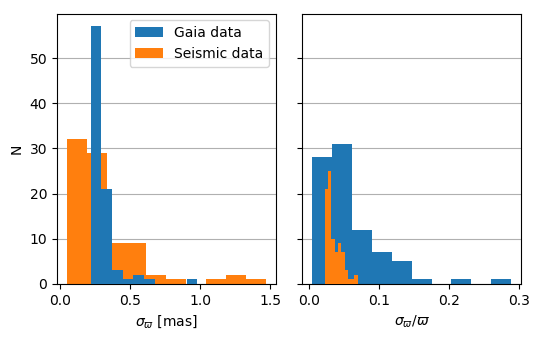

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5.5, 3.5))
ax1.hist(sa.plx_unc, alpha=1, label='Gaia data', zorder=3)
ax1.hist(sa.plx_rad_unc, alpha=1, label='Seismic data', zorder=2)
ax2.hist(sa.plx_unc/sa.plx, alpha=1, label='Gaia data', zorder=2)
ax2.hist(sa.plx_rad_unc/sa.plx_rad, alpha=1, label='Seismic data', zorder=3)

ax1.set_ylabel('N')
ax1.set_xlabel(r'$\sigma_{\varpi}$ [mas]')
ax2.set_xlabel(r'$\sigma_{\varpi} / \varpi$')
ax1.grid(axis='y', zorder=0)
ax2.grid(axis='y', zorder=0)
ax1.legend()

fig.tight_layout()
fig.savefig('figures/plx_hist.pdf')
plt.show()

We see that the Gaia parallaxes have a narrow uncertainty distribution peaking at about 0.3 mas. The seismic parallaxes, on the other hand, have a more narrow distribution in relative parallax peaking near 0.05. Overall, the seismic parallaxes are more precise, but they become less precise for more nearby stars (the ones with large parallaxes).

### Absolute Differences <a class="anchor" id="abs_diff"></a>

We now compare the absolute parallax differences as a function of parallax.

The following code contains functions for calculating parallax differences and ratios, for fitting a polynomial with bootstrapped uncertainty regions, and for plotting parallax differences.

In [15]:
def xy_diff(x, x_unc, y, y_unc):
    '''
    Calculate differences and propagated uncertainties between x and y.
    '''
    diff = x - y
    diff_unc = np.sqrt(x_unc**2 + y_unc**2)

    return diff, diff_unc

def xy_ratio(x, x_unc, y, y_unc):
    '''
    Calculate ratios and propagated uncertainties between x and y.
    '''
    r = x / y
    r_unc = r * np.sqrt((x_unc / x)**2 + (y_unc / y)**2)

    return r, r_unc

def poly_fit(x, y, y_unc, xp_lim, order=1, n_boot=1000):
    '''
    Fit a polynomial of order `order` to the data x,y with
    uncertainties in the y-values. Bootstrapping is applied
    to return lower and upper 1-\sigma uncertainty regions.
    '''
    # Fit a polynomial to the data in the given x-range.
    px = np.linspace(xp_lim[0], xp_lim[1])
    pfit = np.polyfit(x, y, order, w=1/y_unc**2)
    poly = np.poly1d(pfit)
    py = poly(px)

    # Repeat the fit for n_boot bootstrap samples.
    boot_results = np.zeros((n_boot, len(px)))
    for i in range(n_boot):
        rand_per = np.random.randint(len(x), size=len(x))
        synth_x = x[rand_per]
        synth_y = y[rand_per]
        synth_y_unc = y_unc[rand_per]

        pfit = np.polyfit(synth_x, synth_y, order, w=1/synth_y_unc**2)
        poly = np.poly1d(pfit)
        py_temp = poly(px)

        boot_results[i, :] = py_temp

    # Calculate the 16th and 84th percentile at each x-value
    # and return as lower and upper uncertainty regions.
    boot_lower = np.percentile(boot_results, 16, axis=0)
    boot_upper = np.percentile(boot_results, 84, axis=0)
    
    return px, py, boot_lower, boot_upper

In [16]:
def plot_plxdiff(plx, plx_unc, plx_ast, plx_ast_unc, ax, outliers=None, fit=False):
    '''
    Plot parallax differences. Optionally mark a number of stars as outliers and
    perform a linear fit.
    '''
    plx_d, plx_d_unc = xy_diff(plx_ast, plx_ast_unc, plx, plx_unc)

    # Plot outliers in red if given, otherwise plot all
    if outliers is not None:
        bf = np.isin(sa.ID, outliers)
        ax.errorbar(plx[~bf], plx_d[~bf], yerr=plx_d_unc[~bf], marker='o', ms=4,
                    mec='k', linestyle='none', capsize=0, lw=1)
        ax.errorbar(plx[bf], plx_d[bf], yerr=plx_d_unc[bf], marker='o', ms=4,
                    mec='k', linestyle='none', capsize=0, lw=1)
        ax.set_ylim([-2, 12])
    else:
        ax.errorbar(plx, plx_d, yerr=plx_d_unc, marker='o', ms=4,
                    mec='k', linestyle='none', capsize=0, lw=1)
        ax.set_ylim([-2.1, 3])

    # Optionally fit polynomial
    if fit:
        px, py, py_low, py_high = poly_fit(plx, plx_d, plx_d_unc, [1., 100.])
        ax.plot(px, py, c='k', ls='--')
        ax.fill_between(px, py_low, py_high, alpha=0.3)

    ax.axhline(c='k', ls='--', lw=1)
    ax.set_xlim([1, 100])
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel(r'$\varpi_{\mathrm{Gaia}}$ [mas]')
    ax.set_ylabel(r'$\varpi_{\mathrm{Seis}}-\varpi_{\mathrm{Gaia}}$ [mas]')

Before plotting the data we note that a number of the stars have previously been pointed out to have ill determined photometry ([Silva Aguirre et al. (2017)](http://iopscience.iop.org/article/10.3847/1538-4357/835/2/173/meta)). Since the angular diameters we use here are based on photometric observations, we check if these stars are also problematic in this data set. These are the ID numbers of the stars:

In [17]:
bad_ID = [8379927, 7510397, 10454113, 9025370, 1435467, 7940546, 12317678]

We also set new parameters for the plots.

In [18]:
plt.rcParams.update({'xtick.top': True,
                     'ytick.right': True,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.minor.visible': True,
                     'ytick.minor.visible': True})

Here we plot the parallax differences for both sets of seismic parallaxes, and we mark the stars that have ill determined photometry.

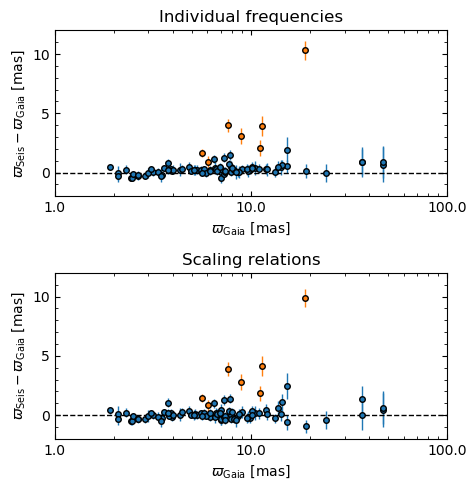

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_plxdiff(sa.plx, sa.plx_unc, sa.plx_rad, sa.plx_rad_unc, ax1, outliers=bad_ID)
plot_plxdiff(sa.plx, sa.plx_unc, sa.plx_scal, sa.plx_scal_unc, ax2, outliers=bad_ID)
ax1.set_title('Individual frequencies')
ax2.set_title('Scaling relations')
fig.tight_layout()
fig.savefig('figures/plxdiff_outliers.pdf')
plt.show()

Clearly, the stars marked in red all have overestimated seismic parallaxes. Since we know that this is most likely due to bad photometry, we define a new dataset where these stars have been removed.
We then plot the differences again with fitted polynomials.

In [20]:
# Pick out stars which are not in the bad_ID list
saf = sa[~np.isin(sa.ID, bad_ID)]

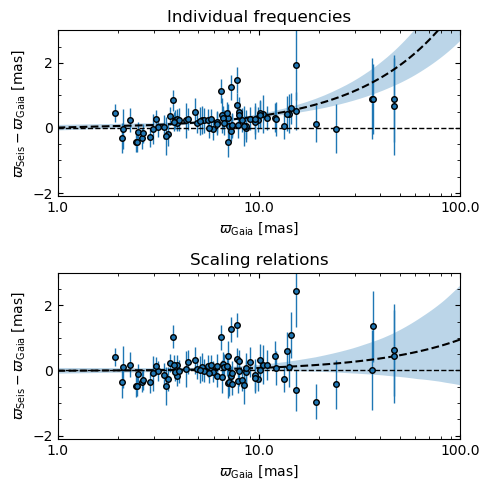

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_plxdiff(saf.plx, saf.plx_unc, saf.plx_rad, saf.plx_rad_unc, ax1, fit=True)
plot_plxdiff(saf.plx, saf.plx_unc, saf.plx_scal, saf.plx_scal_unc, ax2, fit=True)
ax1.set_title('Individual frequencies')
ax2.set_title('Scaling relations')
fig.tight_layout()
fig.savefig('figures/plxdiff_bootstrap.pdf')
plt.show()

It seems that the seismic parallaxes based on the individual frequency analysis are overestimated to a degree which increases with parallax. The seismic parallaxes from the scaling relations, however, show no significant deviations from the Gaia values on average. This is surprising since the analysis using individual frequencies is thought to be more accurate than the approximate scaling relations.

The fact that the offset increases with parallax suggests that there is a fractional error in the seismic radii. In order to test this, the interactive plot below allows one to introduce a fractional offset in the seismic radius. Additionally one can add a constant offset to the Gaia parallaxes since they are known to have potential systematic errors of up to $\pm 0.3$ mas ([Lindegren et al. (2016)](https://www.aanda.org/articles/aa/abs/2016/11/aa28714-16/aa28714-16.html)).
The two sliders give the amount which should be added to Gaia parallaxes and the factor with which the seismic radii should be multiplied.

In [22]:
def plot_plxdiff_int(gaia_offset=0.0, rad_factor=1.00, data='freqs'):
    '''
    Function for interactive plotting of parallax differences.
    It recalculates the seismic parallaxes after applying the factor
    `rad_factor` and it applies the offset `gaia_offset` to the Gaia
    parallaxes before plotting the parallax differences.
    '''
    plx = saf.plx + gaia_offset
    # Choose between radii from individual frequencies or scaling relations
    if data == 'freqs':
        rad = saf.rad * rad_factor
        rad_plx_unc = saf.plx_rad_unc
    elif data == 'scaling':
        rad = saf.rad_scal * rad_factor
        rad_plx_unc = saf.plx_scal_unc

    # Calculate new seismic parallaxes with new radii
    plx_rad = plx_ast(rad, saf.angdiam)

    fig, ax = plt.subplots(figsize=(5,3.5))
    plot_plxdiff(plx, saf.plx_unc, plx_rad, rad_plx_unc, ax, fit=True)
    fig.tight_layout()
    plt.show()

In [23]:
from ipywidgets import interactive
int_plot = interactive(plot_plxdiff_int, gaia_offset=(-0.3, 0.3, 0.02),
                                         rad_factor=(0.9, 1.1, 0.01),
                                         data=['freqs', 'scaling'])
int_plot

interactive(children=(FloatSlider(value=0.0, description='gaia_offset', max=0.3, min=-0.3, step=0.02), FloatSlider(value=1.0, description='rad_factor', max=1.1, min=0.9, step=0.01), Dropdown(description='data', options=('freqs', 'scaling'), value='freqs'), Output()), _dom_classes=('widget-interact',))

Playing around with this plot it is clear that no constant offset to the Gaia parallaxes will remove the trend. However, by multiplying the seismic radii by a factor of about 1.03 it is possible to remove the linear trend seen for the individual frequency results. This suggests that the seismic radii are underestimated by about 3% when using individual frequencies, and that they are accurate when using the scaling relations.

### Relative Differences <a class="anchor" id="rel_diff"></a>

It is also interesting whether the observed offset depends on the stellar parameters like the effective temperature or the metallicity.
In the following we compare the ratios of seismic and Gaia parallaxes as a function of these parameters. The ratios are binned in order to reduce the clutter of the plots.

In [24]:
def binned_ratios(bin_array, bins, r, r_unc):
    '''
    Bin the parallax ratios in `r` according the values in bin_array
    and the given bins.
    The weighted mean and standard deviation of the ratios in each of
    the bins are returned as arrays.
    '''
    # Find out which bin each of the values belong in
    nbins = len(bins)-1
    inds = np.digitize(bin_array, bins, right=True)

    # Initialize arrays
    binx = np.zeros(nbins)
    bin_mean = np.zeros(nbins)
    bin_std = np.zeros(nbins)

    # For each bin the weighted mean and standard deviation of the ratios
    # are calculated and stored
    for i in range(nbins):
        where = np.where(inds == i+1)
        bin_r = r[where]
        bin_r_unc = r_unc[where]

        bin_mean[i] = np.sum(bin_r/bin_r_unc**2) / np.sum(1/bin_r_unc**2)
        bin_std[i] = np.sqrt(1/np.sum(1/bin_r_unc**2))

    return bin_mean, bin_std

In [25]:
def plot_plx_ratio(plx, plx_unc, plx_ast, plx_ast_unc, ax, xax='teff', errors=True,
                   plabel=None):
    '''
    Plot the ratios of seismic and Gaia parallaxes as a
    function of either effective temperature or metallicity.
    Optionally add errobars and labels.
    '''
    # Calculate parallax ratios
    plx_r, plx_r_unc = xy_ratio(plx_ast, plx_ast_unc, plx, plx_unc)
    # Define xaxis bins depending on the xaxis variable
    if xax == 'teff':
        bin_array = saf.teff
        bins = np.arange(5300, 6800, 200, dtype=int)
        bin_centers = np.arange(5400, 6700, 200, dtype=int)
    elif xax == 'feh':
        bin_array = saf.feh
        bins = np.arange(-0.6, 0.45, 0.1)
        bin_centers = np.arange(-0.55, 0.4, 0.1)

    # Calculate and plot binned means and standard deviations
    bin_mean, bin_std = binned_ratios(saf[xax], bins, plx_r, plx_r_unc)
    if errors:
        ax.errorbar(bin_centers, bin_mean, yerr=bin_std, marker='o',
                    c='k', linestyle='--', capsize=0, label=plabel)
    else:
        ax.plot(bin_centers, bin_mean, marker='o', c='k', mfc='none', linestyle=':',
                label=plabel)

def plot_plx_ratios(plx, plx_ast1, plx_ast2, ax, xax='teff',
                    ast_label1=None, ast_label2=None):
    '''
    Plot ratios of seismic and Gaia parallaxes for both sets of seismic
    parallaxes with errorbars only on one of the sets.
    '''
    plot_plx_ratio(*plx, *plx_ast1, ax, xax, errors=True, plabel=ast_label1)
    plot_plx_ratio(*plx, *plx_ast2, ax, xax, errors=False, plabel=ast_label2)
    ax.axhline(y=1, c='k', ls='--', lw=1)
    
    if xax == 'teff':
        ax.set_xlim([5300, 6800])
        ax.set_xlabel('Effective temperature [K]')
    elif xax == 'feh':
        ax.set_xlim([-0.6, 0.4])
        ax.set_xlabel('Metallicity [Fe/H]')
    
    ax.set_ylim([0.95, 1.12])
    ax.set_ylabel(r'$\varpi_{\mathrm{Seis}}$ / $\varpi_{\mathrm{Gaia}}$')
    if ast_label1 is not None or ast_label2 is not None:
        ax.legend(ncol=2)

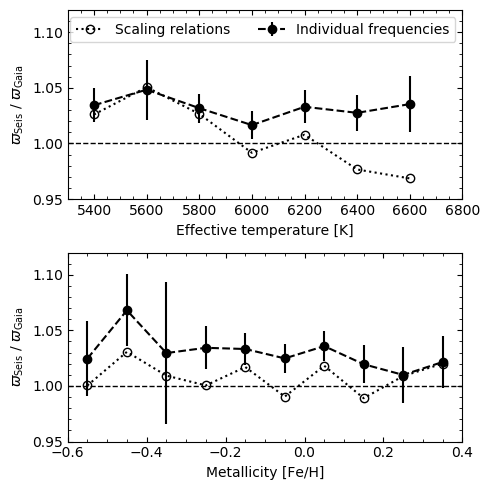

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1)
plot_plx_ratios((saf.plx, saf.plx_unc), (saf.plx_rad, saf.plx_rad_unc),
                (saf.plx_scal, saf.plx_scal_unc), ax1, xax='teff',
                ast_label1='Individual frequencies', ast_label2='Scaling relations')
plot_plx_ratios((saf.plx, saf.plx_unc), (saf.plx_rad, saf.plx_rad_unc),
                (saf.plx_scal, saf.plx_scal_unc), ax2, xax='feh')

fig.tight_layout()
fig.savefig('figures/par_ratio.pdf')
plt.show()

This figure confirms again that the seismic parallaxes from individual frequencies are overestimated by about 3%, but it also shows that this offset is independent of both the stellar temperature and metallicity. For the scaling relations, however, there is a clear trend with temperature. In fact, the offset is also about 3% at the lowest temperatures and then decreases when increasing the temperature. This means that the seismic parallaxes from scaling relations only agree with the Gaia values on average, but not at all temperatures.

It is interesting that the two sets of seismic parallaxes agree at around the solar temperature $T_{\mathrm{eff},\odot} = 5777$ K since this is where the scaling relations are most accurate due to the way they scale relative to the solar values.
It is possible that the offset at the solar temperature is due to a bias in the angular diameters which are used for both sets of seismic parallaxes. In the interactive plot below, it is possible to explore changes in the plot when all angular diameters are multiplied by a common factor. It is also possible to make the factor which is multiplied on the radii temperature dependent.

In [27]:
def plot_plx_ratio_int(gaia_offset=0.0, rad_factor=1.00,
                       rad_scal_factor=1.00, angdiam_factor=1.00,
                       xax='teff', rfactor='const'):
    '''
    Function for interactive plotting of parallax ratios.
    '''
    plx = saf.plx + gaia_offset
    # Choose between a constant factor on the radius or one that
    # increases with temperature to reach the input value at 6600 K.
    if rfactor == 'const':
        rad = saf.rad * rad_factor
        rad_scal = saf.rad_scal * rad_scal_factor
    elif rfactor == 'lin_teff':
        rad = saf.rad * (1 + (rad_factor - 1)*(saf.teff - 5400)/1200)
        rad_scal = saf.rad_scal * (1 + (rad_scal_factor - 1)*(saf.teff - 5400)/1200)
    angdiam = saf.angdiam * angdiam_factor
    
    # Calculate new parallaxes after scaling
    plx_rad = plx_ast(rad, angdiam)
    plx_scal = plx_ast(rad_scal, angdiam)
    
    # Plot ratios
    fig, ax = plt.subplots(figsize=(5.5,3.))
    plot_plx_ratios((plx, saf.plx_unc), (plx_rad, saf.plx_rad_unc),
                    (plx_scal, saf.plx_scal_unc), ax, xax,
                    ast_label1='Individual frequencies', ast_label2='Scaling relations')
    fig.tight_layout()
    plt.show()

In [28]:
int_plot2 = interactive(plot_plx_ratio_int, gaia_offset=(-0.3, 0.3, 0.02),
                                            rad_factor=(0.9, 1.1, 0.01),
                                            rad_scal_factor=(0.9, 1.1, 0.01),
                                            angdiam_factor=(0.9, 1.1, 0.01),
                                            xax=['teff', 'feh'],
                                            rfactor=['const', 'lin_teff'])
int_plot2

interactive(children=(FloatSlider(value=0.0, description='gaia_offset', max=0.3, min=-0.3, step=0.02), FloatSlider(value=1.0, description='rad_factor', max=1.1, min=0.9, step=0.01), FloatSlider(value=1.0, description='rad_scal_factor', max=1.1, min=0.9, step=0.01), FloatSlider(value=1.0, description='angdiam_factor', max=1.1, min=0.9, step=0.01), Dropdown(description='xax', options=('teff', 'feh'), value='teff'), Dropdown(description='rfactor', options=('const', 'lin_teff'), value='const'), Output()), _dom_classes=('widget-interact',))

By playing around with the plot with effective temperature on the xaxis, it is possible to remove the offsets by setting the `angdiam_factor` to 0.97 and by setting the `rad_scal_factor` to 0.95 while `rfactor` is `lin_teff`.
So, if the offset of 3% is due to the angular diameters then the scaling relations must underestimate the seismic parallaxes by about 5% at the highest temperatures considered here -- this means an overestimation of the radii by about 5%.

## Correcting the Scaling Relations <a class="anchor" id="scal_corr"></a>

Finally, by assuming that the 3% offset is due to the angular diameters, we can investigate the correction to the scaling relations which are needed in order to bring the radii and masses into agreement with the ones from the frequency analysis.
We do this by plotting the ratios of the observed and derived values of $\Delta\nu$ and $\nu_{\mathrm{max}}$.

In [29]:
def plot_dm_ratio(teff, logg, dm, dm_unc, dm_scal, dm_scal_unc, ax, data='dnu'):
    '''
    Plot the ratios of $\Delta\nu$ and $\nu_{\mathrm{max}}$ from observations
    and from the scaling relations.
    '''
    # Choose whether input is dnu or numax
    if data == 'dnu':
        polyorder = 2
        ax.set_ylim([0.955, 1.025])
        ax.set_ylabel(r'$\Delta\nu_{\mathrm{obs}}$ / $\Delta\nu_{\mathrm{scaling}}$')
    elif data == 'numax':
        polyorder = 1
        ax.set_ylim([0.955, 1.085])
        ax.set_ylabel(r'$\nu_{\mathrm{max,obs}}$ / $\nu_{\mathrm{max,scaling}}$')
    # Compute and plot ratios with errorbars
    r = xy_ratio(dm, dm_unc, dm_scal, dm_scal_unc)[0]
    r_unc = r*dm_unc/dm
    ax.errorbar(teff, r, yerr=r_unc, linestyle='none',
                c='k', capsize=0, lw=1, zorder=0)
    sc = ax.scatter(teff, r, s=30, c=logg, edgecolors='k',
                    cmap=plt.cm.get_cmap('afmhot'), zorder=1)
    px, py, py_low, py_high = poly_fit(teff, r, r_unc, [5420., 6780.], polyorder)
    ax.plot(px, py, c='k', ls='--')
    ax.fill_between(px, py_low, py_high, alpha=0.3)

    ax.set_xlim([5400, 6800])
    ax.axhline(y=1, c='k', ls='--', lw=1)
    ax.set_xlabel('Effective temperature [K]')
    
    return sc

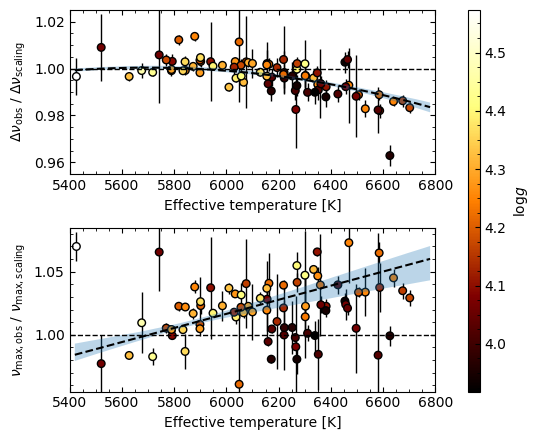

In [30]:
fig = plt.figure(figsize=(5.5, 4.5))
ax1 = plt.subplot2grid((2, 10), (0, 0), rowspan=1, colspan=9)
ax2 = plt.subplot2grid((2, 10), (1, 0), rowspan=1, colspan=9)
axcbar = plt.subplot2grid((2, 10), (0, 9), rowspan=2, colspan=1)
sc = plot_dm_ratio(sa.teff, sa.logg, sa.dnu, sa.dnu_unc, sa.dnu_scal, sa.dnu_scal_unc,
                   ax1, data='dnu')
plot_dm_ratio(sa.teff, sa.logg, sa.numax, sa.numax_unc, sa.numax_scal, sa.numax_scal_unc,
              ax2, data='numax')
fig.colorbar(sc, cax=axcbar, label=r'$\log g$')

fig.tight_layout()
fig.savefig('figures/scal_ratio.pdf')
plt.show()

This comparison shows that the scaling relation for $\nu_{\mathrm{max}}$ shows the largest deviations from the observed values. The two fits (second order to $\Delta\nu$ and first order to $\nu_{\mathrm{max}}$) give reasonable descriptions of the trends; however, there is much scatter around the fit for $\nu_{\mathrm{max}}$.

The two fits can be considered as the factors that needs to be applied to the values of $\Delta\nu$ and $\nu_{\mathrm{max}}$ from the scaling relations in order to make them agree best with the observed values, i.e. corrections to the scaling relations.

## References <a class="anchor" id="ref"></a>

* Chaplin, William J., and Andrea Miglio. "Asteroseismology of solar-type and red-giant stars." Annual Review of Astronomy and Astrophysics 51 (2013).
* Lindegren, L., et al. "Gaia Data Release 1-Astrometry: one billion positions, two million proper motions and parallaxes." Astronomy & Astrophysics 595 (2016): A4.
* Silva Aguirre, V., et al. "Verifying asteroseismically determined parameters of Kepler stars using Hipparcos parallaxes: self-consistent stellar properties and distances." The Astrophysical Journal 757.1 (2012): 99.
* Silva Aguirre, V., et al. "Ages and fundamental properties of Kepler exoplanet host stars from asteroseismology." Monthly Notices of the Royal Astronomical Society 452.2 (2015): 2127-2148.
* Silva Aguirre, Víctor, et al. "Standing on the Shoulders of Dwarfs: the Kepler Asteroseismic LEGACY Sample. II. Radii, Masses, and Ages." The Astrophysical Journal 835.2 (2017): 173.